In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import networkx as nx
from collections import Counter
import ipywidgets as ipw
import io

from utils import niceprint, explore_branching_factors

In [2]:
%matplotlib inline

In [3]:
np.random.seed(1)

In [4]:
def without_diag(X):
    return X - np.diag(np.diag(X))

In [5]:
def B(a):
    numer = np.prod(gamma(a))
    denom = gamma(np.sum(a))
    return numer / denom

In [6]:
def g(x, indices):
    y = np.asarray(x).copy()
    np.add.at(y, indices, 1)
    return y

In [7]:
def f(a, i1, i2):
    s = np.sum(a)
    if i1 == i2:
        return (a[i1] + 1) * a[i1] / ((1 + s) * s)
    else:
        return a[i1] * a[i2] / ((1 + s) * s)

In [8]:
f(np.ones(3), 1, 2)

0.083333333333333329

In [9]:
B(g(np.ones(3), [1, 2])) / B(np.ones(3))

0.083333333333333329

In [10]:
def calc_cooccurrence(alpha_leaves, alpha_depths, leaves, path1, path2):
    result = f(alpha_depths, len(path1), len(path2))
    factor = 0
    for j1, p1 in enumerate(leaves):
        if p1[:len(path1)] != path1:
            continue
        for j2, p2 in enumerate(leaves):
            if p2[:len(path2)] != path2:
                continue
            factor += f(alpha_leaves, j1, j2)
    result *= factor
    return result

def calc_cooccurrence_matrix(alpha_leaves, alpha_depths, branching_factors):
    nodes = explore_branching_factors(branching_factors)
    max_depth = len(branching_factors)
    leaves = [x for x in nodes if len(x) == max_depth]
    alpha_leaves = alpha_leaves * np.ones(len(leaves))
    alpha_depths = alpha_depths * np.ones(1 + max_depth)
    num_nodes = len(nodes)
    result = np.zeros((num_nodes, num_nodes))
    for i1, p1 in enumerate(nodes):
        for i2, p2 in enumerate(nodes):
            result[i1, i2] = calc_cooccurrence(
                alpha_leaves = alpha_leaves,
                alpha_depths = alpha_depths,
                leaves = leaves,
                path1 = p1,
                path2 = p2)
    return result

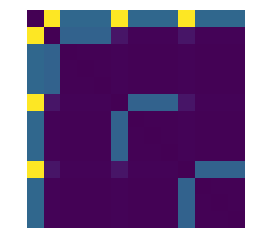

In [11]:
R = calc_cooccurrence_matrix(
    alpha_leaves = 0.01,
    alpha_depths = 1.0,
    branching_factors = [3, 3])

fig, ax = plt.subplots()
plt.imshow(without_diag(R))
plt.axis('off');

In [12]:
niceprint(R, precision=5)

[[0.16667 0.02778 0.00926 0.00926 0.00926 0.02778 0.00926 0.00926 0.00926 0.02778 0.00926 0.00926 0.00926]
 [0.02778 0.05250 0.00875 0.00875 0.00875 0.00153 0.00025 0.00025 0.00025 0.00153 0.00025 0.00025 0.00025]
 [0.00926 0.00875 0.01716 0.00017 0.00017 0.00025 0.00017 0.00017 0.00017 0.00025 0.00017 0.00017 0.00017]
 [0.00926 0.00875 0.00017 0.01716 0.00017 0.00025 0.00017 0.00017 0.00017 0.00025 0.00017 0.00017 0.00017]
 [0.00926 0.00875 0.00017 0.00017 0.01716 0.00025 0.00017 0.00017 0.00017 0.00025 0.00017 0.00017 0.00017]
 [0.02778 0.00153 0.00025 0.00025 0.00025 0.05250 0.00875 0.00875 0.00875 0.00153 0.00025 0.00025 0.00025]
 [0.00926 0.00025 0.00017 0.00017 0.00017 0.00875 0.01716 0.00017 0.00017 0.00025 0.00017 0.00017 0.00017]
 [0.00926 0.00025 0.00017 0.00017 0.00017 0.00875 0.00017 0.01716 0.00017 0.00025 0.00017 0.00017 0.00017]
 [0.00926 0.00025 0.00017 0.00017 0.00017 0.00875 0.00017 0.00017 0.01716 0.00025 0.00017 0.00017 0.00017]
 [0.02778 0.00153 0.00025 0.00025 0.0

In [13]:
def to_weighted_graph(X, weight_func = None):
    if weight_func is None:
        weight_func = lambda w, v: 0.5 * (w + v)
    g = nx.Graph()
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if i <= j:
                c = weight_func(X[i,j], X[j,i])
                g.add_edge(i, j, weight = c)
    return g

In [14]:
def _bfs_layout_helper(tree, source, spacing, center):
    pos = dict()
    results_by_child = []
    for n in sorted(tree.neighbors(source)):
        results_by_child.append(_bfs_layout_helper(tree, n, spacing, center))
    pos[source] = center
    width = 0.0
    for i, (subtree_pos, subtree_width) in enumerate(results_by_child):
        if i > 0:
            width += spacing[0]
        width += subtree_width
    shiftx = -width / 2.0
    for subtree_pos, subtree_width in results_by_child:
        shiftx += subtree_width / 2.0
        for k, (x, y) in subtree_pos.items():
            pos[k] = (x + shiftx, y - spacing[1])
        shiftx += subtree_width / 2.0 + spacing[0]
    return pos, width

def bfs_layout(G, sources=None, spacing=(1.0, 1.0), center=(0.0, 0.0)):
    pos = dict()
    if G.number_of_nodes() == 0:
        return pos
    if sources is None:
        sources = []
    if G.is_directed():
        components = nx.algorithms.weakly_connected_component_subgraphs(G)
    else:
        components = nx.algorithms.connected_component_subgraphs(G)
    cumulative_width = 0
    for comp in components:
        current_source = None
        for s in sources:
            if s in comp.nodes():
                current_source = s
                break
        if current_source is None:
            current_source = list(comp.nodes())[0]
        tree = nx.bfs_tree(G, current_source)
        current_pos, width = _bfs_layout_helper(tree, current_source, spacing, center)
        for k in current_pos.keys():
            current_pos[k] = (current_pos[k][0] + cumulative_width, current_pos[k][1])
        pos.update(current_pos)
        cumulative_width += width + spacing[0]
    return pos

In [15]:
g = to_weighted_graph(-R)
tree = nx.algorithms.minimum_spanning_tree(g)
print("Maximum spanning tree:")
print(tree.edges())

Maximum spanning tree:
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12)]


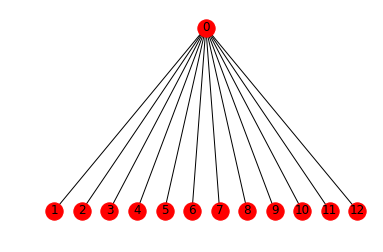

In [16]:
fig, ax = plt.subplots()
nx.draw(tree, pos=bfs_layout(tree, sources=[0]), ax=ax, with_labels=True);

[[0.0000 0.0833 0.0278 0.0278 0.0278 0.0833 0.0278 0.0278 0.0278 0.0833 0.0278 0.0278 0.0278]
 [0.0833 0.0000 0.0787 0.0787 0.0787 0.0138 0.0023 0.0023 0.0023 0.0138 0.0023 0.0023 0.0023]
 [0.0278 0.0787 0.0000 0.0046 0.0046 0.0023 0.0046 0.0046 0.0046 0.0023 0.0046 0.0046 0.0046]
 [0.0278 0.0787 0.0046 0.0000 0.0046 0.0023 0.0046 0.0046 0.0046 0.0023 0.0046 0.0046 0.0046]
 [0.0278 0.0787 0.0046 0.0046 0.0000 0.0023 0.0046 0.0046 0.0046 0.0023 0.0046 0.0046 0.0046]
 [0.0833 0.0138 0.0023 0.0023 0.0023 0.0000 0.0787 0.0787 0.0787 0.0138 0.0023 0.0023 0.0023]
 [0.0278 0.0023 0.0046 0.0046 0.0046 0.0787 0.0000 0.0046 0.0046 0.0023 0.0046 0.0046 0.0046]
 [0.0278 0.0023 0.0046 0.0046 0.0046 0.0787 0.0046 0.0000 0.0046 0.0023 0.0046 0.0046 0.0046]
 [0.0278 0.0023 0.0046 0.0046 0.0046 0.0787 0.0046 0.0046 0.0000 0.0023 0.0046 0.0046 0.0046]
 [0.0833 0.0138 0.0023 0.0023 0.0023 0.0138 0.0023 0.0023 0.0023 0.0000 0.0787 0.0787 0.0787]
 [0.0278 0.0023 0.0046 0.0046 0.0046 0.0023 0.0046 0.0046 0.

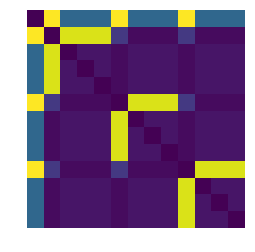

In [17]:
Rcond = R / np.sum(R, axis=0, keepdims=True)
Rcondp = np.minimum(Rcond, Rcond.T)
Rcondp -= np.diag(np.diag(Rcondp))

niceprint(Rcondp)

fig, ax = plt.subplots()
ax.imshow(Rcondp);
ax.axis('off');

[(0, 9), (0, 5), (0, 1), (1, 2), (1, 3), (1, 4), (5, 8), (5, 6), (5, 7), (9, 10), (9, 11), (9, 12)]


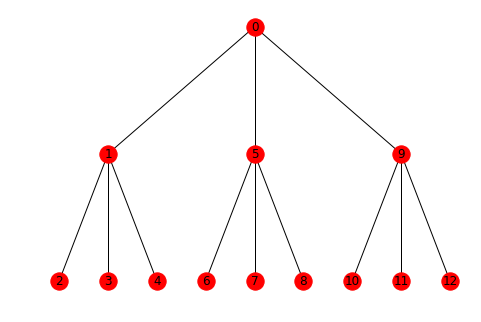

In [18]:
g2 = to_weighted_graph(-Rcondp)
tree2 = nx.algorithms.minimum_spanning_tree(g2)
print(tree2.edges())
nx.draw(tree2, pos = bfs_layout(tree2, sources=[0]), with_labels = True)

In [19]:
# Example output sent by Stefanos
zzz = np.loadtxt(io.StringIO('''\
0.0722248774154017 0.0184328604378913 0.0183675728897166 0.0195812977278527 0.011715651036256 0.0109362130364248 0.0103053405295851 0.0118149764469529 0.0107629960798506 0.0101972359982806 0.010533390695229 0.0106724843592029 0.011287010156071
0.0184328604378913 0.0197880734142364 0.00800884204285961 0.00867787380547044 0.00442376470031421 0.00643217108265574 0.00585968293137737 0.00448944131937417 0.0042002100095913 0.00383982410082561 0.0041179061240953 0.00564921482263275 0.00435908438938697
0.0183675728897166 0.00800884204285961 0.0185305916929322 0.00810817551625466 0.00437124231289586 0.00401565677211632 0.00399134528877907 0.00625630184806425 0.00403427290544172 0.00373911413202784 0.00556387292190846 0.00397063351721975 0.00631659797495848
0.0195812977278527 0.00867787380547043 0.00810817551625466 0.020223678809002 0.00636646213109489 0.00430013301916319 0.00421449379607564 0.0044949224119127 0.00605416561565558 0.00569183622214723 0.00420827207219966 0.00404823371268847 0.00454457318156866
0.011715651036256 0.00442376470031421 0.00437124231289586 0.00636646213109489 0.00794116107247916 0.00280086263128064 0.00282800354338402 0.00316128051767623 0.00276178704793014 0.00265560091211258 0.00273054106944284 0.00271228502453686 0.00298357666010662
0.0109362130364248 0.00643217108265574 0.00401565677211632 0.00430013301916319 0.00280086263128064 0.00751398796980115 0.00268945454897023 0.00293987684605933 0.00259113925060299 0.0024274506495169 0.00261898032272799 0.00277363530771859 0.0027505146918834
0.0103053405295851 0.00585968293137737 0.00399134528877907 0.00421449379607564 0.00282800354338402 0.00268945454897023 0.00653691289753865 0.00285730870692366 0.00243143012620175 0.00236647957352213 0.00236198358015604 0.00255338926950333 0.00274618984239741
0.0118149764469529 0.00448944131937417 0.00625630184806426 0.0044949224119127 0.00316128051767623 0.00293987684605933 0.00285730870692366 0.00765506483635657 0.00279346352302565 0.00266479628228487 0.00281882786236071 0.00274243398056417 0.00298329855291249
0.0107629960798506 0.0042002100095913 0.00403427290544172 0.00605416561565559 0.00276178704793014 0.00259113925060299 0.00243143012620175 0.00279346352302565 0.00638002019952813 0.00238402186156206 0.00259146984608675 0.00253730152042142 0.00272000260061857
0.0101972359982806 0.00383982410082561 0.00373911413202784 0.00569183622214723 0.00265560091211258 0.0024274506495169 0.00236647957352213 0.00266479628228487 0.00238402186156206 0.00574249459639133 0.00240586369948643 0.0023356999853139 0.00249112070788169
0.010533390695229 0.0041179061240953 0.00556387292190846 0.00420827207219966 0.00273054106944284 0.00261898032272799 0.00236198358015604 0.00281882786236071 0.00259146984608675 0.00240586369948643 0.00592666601381645 0.00248921198229705 0.00259160203194373
0.0106724843592029 0.00564921482263275 0.00397063351721975 0.00404823371268847 0.00271228502453686 0.00277363530771859 0.00255338926950334 0.00274243398056417 0.00253730152042142 0.0023356999853139 0.00248921198229705 0.00579401081562425 0.00256712527710104
0.011287010156071 0.00435908438938698 0.00631659797495848 0.00454457318156866 0.00298357666010662 0.0027505146918834 0.00274618984239741 0.00298329855291249 0.00272000260061857 0.00249112070788169 0.00259160203194374 0.00256712527710104 0.00611574044572484
'''))

In [20]:
zzz.shape

(13, 13)

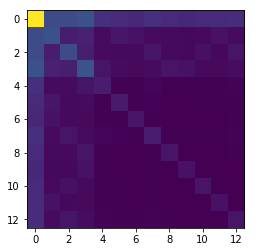

In [21]:
plt.imshow(zzz);

In [22]:
def apply_transformation(X):
    Xcond = X / X.sum(axis = 0, keepdims = True)
    return np.minimum(Xcond, Xcond.T)

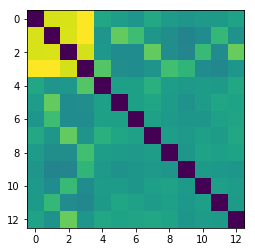

In [23]:
plt.imshow(without_diag(apply_transformation(zzz)));

[(0, 3), (1, 11), (1, 2), (1, 3), (1, 5), (1, 6), (2, 10), (2, 12), (2, 7), (3, 4), (3, 8), (3, 9)]


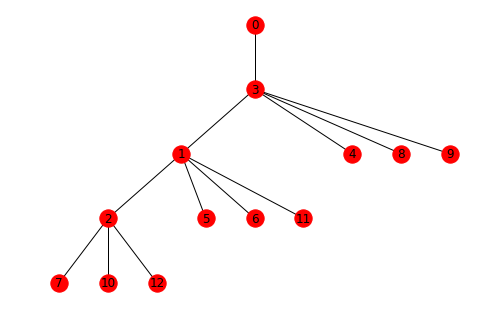

In [24]:
ttt = nx.algorithms.maximum_spanning_tree(to_weighted_graph(apply_transformation(zzz)))
print(list(ttt.edges()))
nx.draw(ttt, pos=bfs_layout(ttt, sources=[0]), with_labels=True);

[[0.1667 0.0278 0.0278 0.0278 0.0093 0.0093 0.0093 0.0093 0.0093 0.0093 0.0093 0.0093 0.0093]
 [0.0278 0.0525 0.0015 0.0015 0.0087 0.0087 0.0087 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003]
 [0.0278 0.0015 0.0525 0.0015 0.0003 0.0003 0.0003 0.0087 0.0087 0.0087 0.0003 0.0003 0.0003]
 [0.0278 0.0015 0.0015 0.0525 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0087 0.0087 0.0087]
 [0.0093 0.0087 0.0003 0.0003 0.0172 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002]
 [0.0093 0.0087 0.0003 0.0003 0.0002 0.0172 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002]
 [0.0093 0.0087 0.0003 0.0003 0.0002 0.0002 0.0172 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002]
 [0.0093 0.0003 0.0087 0.0003 0.0002 0.0002 0.0002 0.0172 0.0002 0.0002 0.0002 0.0002 0.0002]
 [0.0093 0.0003 0.0087 0.0003 0.0002 0.0002 0.0002 0.0002 0.0172 0.0002 0.0002 0.0002 0.0002]
 [0.0093 0.0003 0.0087 0.0003 0.0002 0.0002 0.0002 0.0002 0.0002 0.0172 0.0002 0.0002 0.0002]
 [0.0093 0.0003 0.0003 0.0087 0.0002 0.0002 0.0002 0.0002 0.

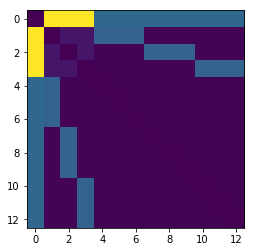

In [25]:
temp_reorder = [0, 1, 5, 9, 2, 3, 4, 6, 7, 8, 10, 11, 12]
temp_R = R[np.atleast_2d(temp_reorder).T, temp_reorder]

niceprint(temp_R)

plt.imshow(without_diag(temp_R));

In [26]:
def demo(alpha_leaves, alpha_depths):
    R = calc_cooccurrence_matrix(
        alpha_leaves = alpha_leaves,
        alpha_depths = alpha_depths,
        branching_factors = [3, 3])
    Rcond = R / R.sum(axis=0, keepdims=True)
    Rcondp = np.minimum(Rcond, Rcond.T)
    graph = nx.from_numpy_array(Rcondp)
    tree = nx.algorithms.maximum_spanning_tree(graph)
    pos = bfs_layout(tree, sources=[0])
    gridshape = np.asarray([1, 4])
    fig, ax = plt.subplots(*gridshape, figsize=4*gridshape[::-1])
    ax[0].imshow(without_diag(R))
    ax[0].axis('off')
    ax[0].set_title("R")
    ax[1].imshow(without_diag(Rcond))
    ax[1].axis('off')
    ax[1].set_title("Rcond")
    ax[2].imshow(without_diag(Rcondp))
    ax[2].axis('off')
    ax[2].set_title("minimum(Rcond, Rcond.transpose())")
    nx.draw(tree, pos=pos, with_labels=True, ax=ax[3])
    ax[3].axis('off')
    ax[3].set_title("Maximum Spanning Tree")
    fig.suptitle(r"Analysis for $\alpha_\mathrm{{leaves}} = {}, \alpha_\mathrm{{depths}} = {}$".format(alpha_leaves, alpha_depths))

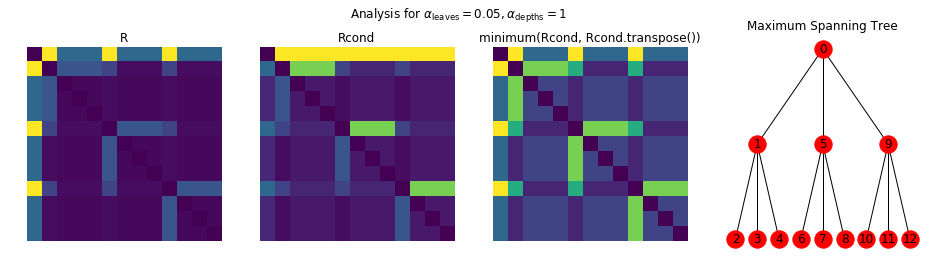

In [27]:
demo(alpha_leaves = 0.05, alpha_depths = 1)

In [28]:
# ipw.interact(
#     demo,
#     alpha_leaves = ipw.BoundedFloatText(0.5, min=0.05, max=10, step=0.05),
#     alpha_depths = ipw.BoundedFloatText(1.0, min=0.05, max=10, step=0.05));

In [29]:
perm = np.random.permutation(R.shape[0])
perm

array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9,  8, 11,  5])

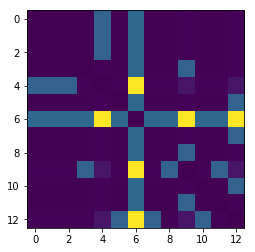

In [30]:
temp_R = R[perm.reshape((-1,1)), perm.reshape((1,-1))]
plt.imshow(without_diag(temp_R));

In [31]:
temp_R.sum(axis=0)

array([ 0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.11111111,
        0.03703704,  0.33333333,  0.03703704,  0.03703704,  0.11111111,
        0.03703704,  0.03703704,  0.11111111])

In [32]:
def extract_tree_helper(X, root_index, branching_factors, indices):
    g = nx.Graph()
    root = indices[root_index]
    g.add_node(root)
    if len(branching_factors) == 0:
        return g

    num_children = branching_factors[0]
    remaining_branching_factors = branching_factors[1:]
    descendants_per_child = int(np.prod(remaining_branching_factors))

    assert len(indices) >= num_children
    assert X.shape[0] == X.shape[1]
    assert X.shape[0] == len(indices), "{} vs {}".format(X.shape[0], len(indices))
    if len(indices) == num_children:
        for i in indices:
            g.add_edge(root, i)
        return g

    mask_child_candidates = np.ones(indices.shape, dtype='bool')
    mask_child_candidates[root_index] = False
    children_indirect = np.argpartition(X[root_index, mask_child_candidates], -num_children)[-num_children:]
    children = np.where(mask_child_candidates)[0][children_indirect]

    mask_candidates = np.ones(indices.shape, dtype='bool')
    mask_candidates[root_index] = False
    mask_candidates[children] = False

    for c in children:
        to_recurse = [c]
        indirect = np.argpartition(X[c, mask_candidates], -descendants_per_child)[-descendants_per_child:]
        to_recurse.extend(np.where(mask_candidates)[0][indirect])
        to_recurse_col = np.reshape(to_recurse, (-1, 1))
        # Compute subtree and add to graph
        Xsub = X[to_recurse_col, to_recurse_col.T]
        remaining_indices = indices[to_recurse]
        subtree = extract_tree_helper(Xsub, 0, remaining_branching_factors, remaining_indices)
        g = nx.compose(g, subtree)
        g.add_edge(root, indices[c])
        # Update candidates
        mask_candidates[to_recurse] = False

    return g

def extract_tree(X, branching_factors):
    indices = np.arange(X.shape[0])
    p_node = X.sum(axis = 0)
    root = np.argmax(p_node)
    g = extract_tree_helper(X, root, branching_factors, indices)
    g.graph["root"] = root
    return g

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[(0, 4), (1, 4), (2, 4), (3, 9), (4, 6), (5, 12), (6, 12), (6, 9), (7, 12), (8, 9), (9, 11), (10, 12)]


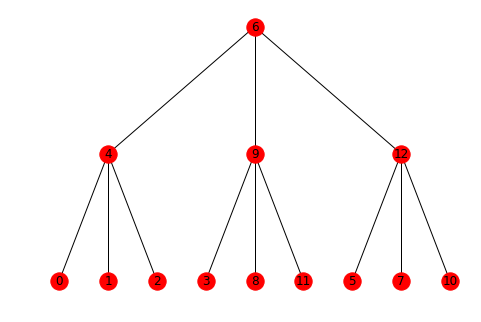

In [33]:
g = extract_tree(temp_R, branching_factors = [3, 3])
print(g.nodes())
print(g.edges())
nx.draw(g, pos=bfs_layout(g, sources=[g.graph["root"]]), with_labels=True)

In [34]:
def invert_permutation(p):
    p = np.asarray(p)
    result = np.empty(p.shape, dtype='int')
    result[p] = np.arange(p.size)
    return result

In [35]:
def demo2(seed, alpha_leaves, alpha_depths):
    branching_factors = [3, 3]
    R = calc_cooccurrence_matrix(
        alpha_leaves = alpha_leaves,
        alpha_depths = alpha_depths,
        branching_factors = branching_factors)

    rand = np.random.RandomState(seed)
    perm = rand.permutation(R.shape[0])
    R = R[perm.reshape((-1, 1)), perm.reshape((1, -1))]

    tree = extract_tree(R, branching_factors=branching_factors)
    pos = bfs_layout(tree, sources=[tree.graph["root"]])
    gridshape = np.asarray([1, 3])
    fig, ax = plt.subplots(*gridshape, figsize=4*gridshape[::-1])
    ax[0].imshow(without_diag(R))
    ax[0].axis('off')
    ax[0].set_title("R")
    nx.draw(tree, pos=pos, with_labels=True, ax=ax[1])
    ax[1].axis('off')
    ax[1].set_title("Maximum Spanning Tree")
    nx.draw(tree, pos=pos, labels={i: j for i, j in enumerate(perm)}, ax=ax[2])
    ax[2].axis('off')
    ax[2].set_title("Maximum Spanning Tree (relabeled)")
    fig.suptitle(r"Analysis for $\alpha_\mathrm{{leaves}} = {}, \alpha_\mathrm{{depths}} = {}, seed = {}$".format(alpha_leaves, alpha_depths, seed))

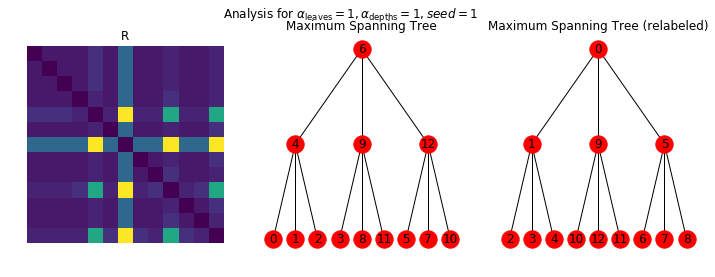

In [36]:
demo2(seed=1, alpha_leaves=1, alpha_depths=1)

In [37]:
ipw.interact(
    demo2,
    seed = ipw.IntText(1),
    alpha_leaves = ipw.BoundedFloatText(0.5, min=0.05, max=10, step=0.05),
    alpha_depths = ipw.BoundedFloatText(1.0, min=0.05, max=10, step=0.05));

interactive(children=(IntText(value=1, description='seed'), BoundedFloatText(value=0.5, description='alpha_leaves', max=10.0, min=0.05, step=0.05), BoundedFloatText(value=1.0, description='alpha_depths', max=10.0, min=0.05, step=0.05), Output()), _dom_classes=('widget-interact',))

In [38]:
a = np.array([1,3,2,0])
b = invert_permutation(a)
a, b, a[b], b[a]

(array([1, 3, 2, 0]),
 array([3, 0, 2, 1]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]))

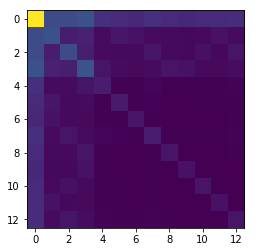

In [39]:
plt.imshow(zzz);

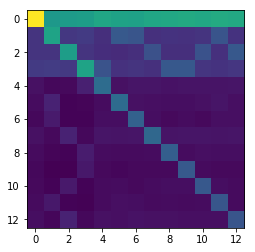

In [40]:
zzz_cond = zzz / zzz.sum(axis=0, keepdims=True)
plt.imshow(zzz_cond);

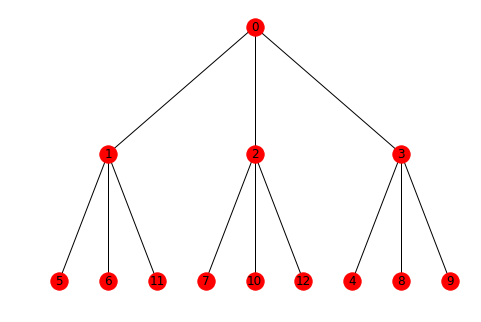

In [41]:
ttt = extract_tree(zzz, branching_factors=[3,3])
nx.draw(ttt, pos=bfs_layout(ttt, sources=[ttt.graph["root"]]), with_labels=True)

In [42]:
def cond_discrep(X, triu=False, cutoff=None, top_k=None):
    Xcond = X / X.sum(axis=0, keepdims=True)
    Y = Xcond - Xcond.T
    if cutoff is not None:
        Y[Y < cutoff] = 0
    elif top_k is not None:
        cutoff = np.partition(Y.flatten(), -top_k)[-top_k]
        Y[Y < cutoff] = 0
    if triu:
        Y = np.triu(Y)
    return Y

def imshow_symmetric(X, ax=None, v=None, cmap='seismic'):
    if v is None:
        v = np.max(np.abs(X))
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(X, vmin=-v, vmax=v, cmap=cmap)
    #ax.axis('off')

def viz(X, ax=None, v=None, cmap='seismic', **kwargs):
    Y = cond_discrep(X, **kwargs)
    imshow_symmetric(Y, ax=ax, v=v, cmap=cmap)

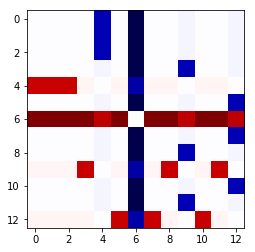

In [43]:
viz(temp_R)

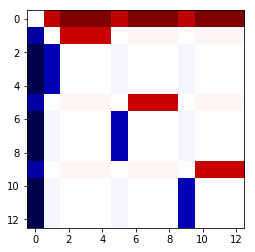

In [44]:
viz(R)

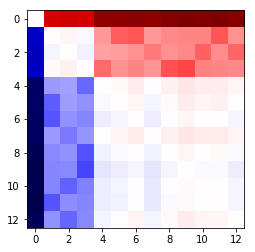

In [45]:
viz(zzz)

In [46]:
def permute_square(X, perm):
    perm = np.asarray(perm).reshape((-1, 1))
    return X[perm, perm.T]

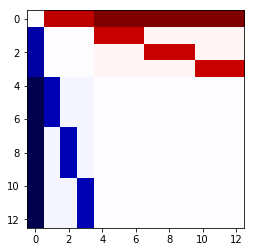

In [47]:
viz(permute_square(R, [0, 1, 5, 9, 2, 3, 4, 6, 7, 8, 10, 11, 12]))

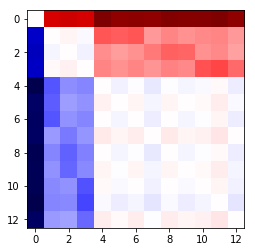

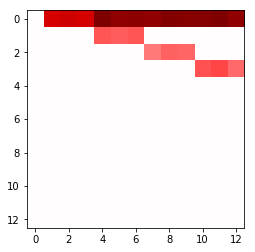

In [48]:
viz(permute_square(zzz, [0, 1, 2, 3, 11, 5, 6, 7, 10, 12, 8, 9, 4]))
viz(permute_square(zzz, [0, 1, 2, 3, 11, 5, 6, 7, 10, 12, 8, 9, 4]), top_k=12+9)

In [49]:
def demo3(X, branching_factors):
    tree = extract_tree(X, branching_factors=branching_factors)
    pos = bfs_layout(tree, sources=[tree.graph["root"]])
    gridshape = np.asarray([1, 2])
    fig, ax = plt.subplots(*gridshape, figsize=4*gridshape[::-1])
    ax[0].imshow(without_diag(X))
    ax[0].axis('off')
    ax[0].set_title("R")
    nx.draw(tree, pos=pos, with_labels=True, ax=ax[1])
    ax[1].axis('off')
    ax[1].set_title("Maximum Spanning Tree")

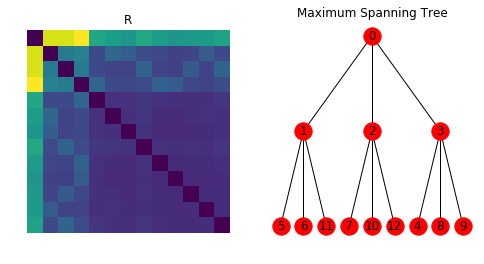

In [53]:
demo3(zzz, branching_factors=[3,3])

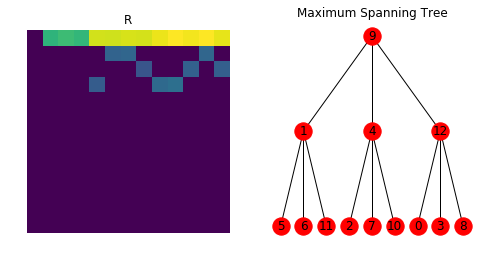

In [54]:
demo3(cond_discrep(zzz, top_k=12+9), branching_factors=[3,3])